In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.plot_helpers import *
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean
import os
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")
import hvplot.xarray
import hvplot
hvplot.output(widget_location='bottom')

In [2]:
M4 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/bare/output/longmean_00029050.nc', decode_times=False)
M4_smooth_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-filter-3D/output/longmean_00029050.nc', decode_times=False)
M4_reynolds_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Reynolds-newest-code/output/longmean_00029050.nc', decode_times=False)

#M4_smooth_strong = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Smooth-3.0/output/longmean_00029050.nc', decode_times=False)
#M4_reynolds_strong = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Reynolds-3.0/output/longmean_00029050.nc', decode_times=False)

M4_JH = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/JansenHeld-Cs-0.2-Cback-0.1/output/longmean_00029050.nc', decode_times=False)
#M4_yankovsky_strong = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Yankovsky23/output/longmean_00029050.nc', decode_times=False)
M4_yankovsky_weak = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R4-long/Yankovsky23-0.3/output/longmean_00029050.nc', decode_times=False)

M32 = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/longmean*.nc', decode_times=False)

In [47]:
def ACC_mean(ds):
    '''
    Computation from averaged statistics
    '''
    return (ds.uh.isel(xq=0)).sum(['yh', 'zl']) * 1e-6

In [15]:
from functools import cache
@cache
def ACC_snapshot(exp='R4-long/bare'):
    '''
    Computation from snapshots
    '''
    if exp=='R32':
        ds = xr.open_mfdataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/snapshots*.nc', decode_times=False).isel(time=slice(None,None,6))
        static = xr.open_dataset('/scratch/pp2681/mom6/Neverworld2/simulations/R32/static.nc', decode_times=False)
    else:
        try:
            ds = xr.open_dataset(f'/scratch/pp2681/mom6/Neverworld2/simulations/{exp}/output/snapshots_00029010.nc', decode_times=False).isel(time=slice(-27,None))
        except:
            try:
                ds = xr.open_dataset(f'/scratch/pp2681/mom6/Neverworld2/simulations/{exp}/output/snapshots_00029020.nc', decode_times=False).isel(time=slice(-27,None))
            except:
                return xr.DataArray([np.nan]*27)
        static = xr.open_dataset(f'/scratch/pp2681/mom6/Neverworld2/simulations/{exp}/output/static.nc', decode_times=False)

    u = ds.u.sel(xq=0).load()
    h = ds.h.isel(xh=[0,-1]).load()
    h_interp = (h.isel(xh=0) + h.isel(xh=-1)) * 0.5
    dyCu = static.dyCu.sel(xq=0).load()

    transport = u*h_interp*dyCu
    
    return transport.sum(['yh', 'zl']) * 1e-6

(0.0, 300.0)

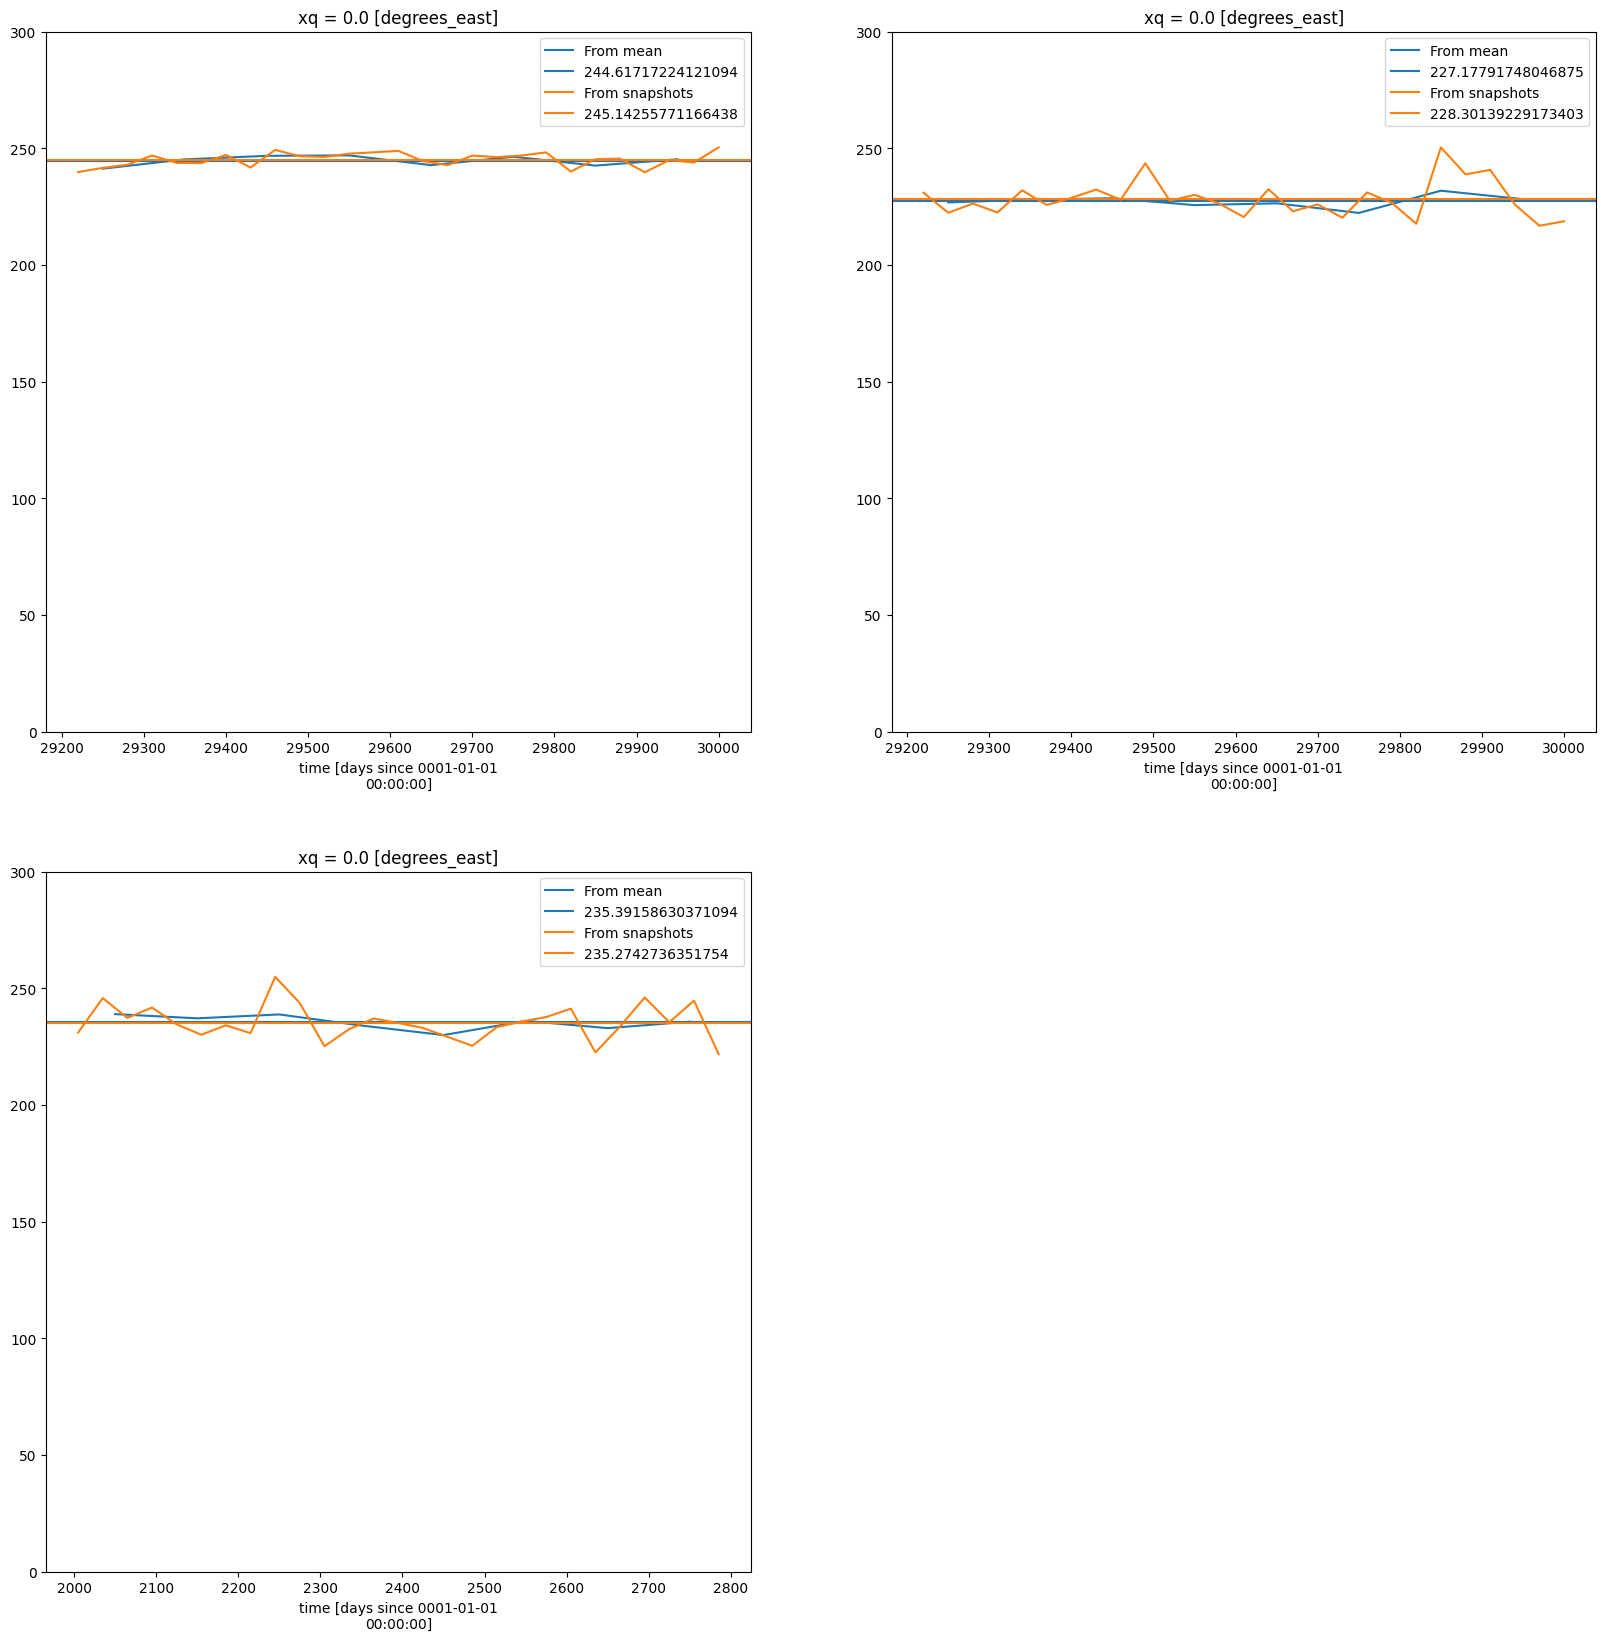

In [48]:
def plot(acc, label=None, color='tab:blue'):
    acc.plot(label=label)
    plt.axhline(acc.mean(), color=color, label=float(acc.mean()))
    plt.legend()

plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
acc = ACC_mean(M4)[2:]
plot(acc, 'From mean', 'tab:blue')
acc = ACC_snapshot('R4-long/bare')
plot(acc, 'From snapshots', 'tab:orange')
plt.ylim([0, 300])

plt.subplot(2,2,2)
acc = ACC_mean(M4_smooth_weak)[2:]
plot(acc, 'From mean', 'tab:blue')
acc = ACC_snapshot('R4-long/Smooth-filter-3D')
plot(acc, 'From snapshots', 'tab:orange')
plt.ylim([0, 300])

plt.subplot(2,2,3)
acc = ACC_mean(M32)[2:]
plot(acc, 'From mean', 'tab:blue')
acc = ACC_snapshot('R32')
plot(acc, 'From snapshots', 'tab:orange')
plt.ylim([0, 300])

In [52]:
print('ACC in Sv averaged over last 800 days:')
print('1/32: %.1f' % float(ACC_snapshot('R32').mean()))
print('1/4: %.1f' % float(ACC_snapshot('R4-long/bare').mean()))
print('1/4, YBSZ23: %.1f' % float(ACC_snapshot('R4-long/Yankovsky23-0.3').mean()))
print('1/4, ZB20-Smooth: %.1f' % float(ACC_snapshot('R4-long/Smooth-filter-3D').mean()))
print('1/4, ZB20-Reynolds: %.1f' % float(ACC_snapshot('R4-long/Reynolds-newest-code').mean()))

ACC in Sv averaged over last 800 days:
1/32: 235.3
1/4: 245.1
1/4, YBSZ23: 229.9
1/4, ZB20-Smooth: 228.3
1/4, ZB20-Reynolds: 225.4
